# Patch based Data Loading for Training

In [1]:
import os

import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

from viz_utils import NdimageVisualizer

In [2]:
visualizer = NdimageVisualizer()

In [3]:
EXTENSIONS = ['.nrrd']

OUT_OF_BODY_HU = -1024
OUT_OF_BODY_SUV = 0

## General utils

In [4]:
def load(file_path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    sitk_image = reader.Execute()
    return sitk_image

def get_npy(sitk_image):
    return sitk.GetArrayFromImage(sitk_image)

def min_max_normalize(image, min_value, max_value):
    image = image.float()
    image = (image - min_value) / (max_value - min_value)
    return 2 * image - 1

def apply_body_mask(image_dict):
    body_mask = image_dict['body-mask']

    for k in image_dict.keys():
        if 'PET' in k:
            image_dict[k] = np.where(body_mask, image_dict[k], OUT_OF_BODY_SUV)
        elif 'CT' in k:
            image_dict[k] = np.where(body_mask, image_dict[k], OUT_OF_BODY_HU)

    return image_dict


def sitk2np(image_dict):
    # WHD to DHW
    for k in image_dict.keys():
        image_dict[k] = get_npy(image_dict[k])
    return image_dict

def np2tensor(image_dict):
    for k in image_dict.keys():
        image_dict[k] = torch.tensor(image_dict[k])
    return image_dict

## Patch sampling utils

In [5]:
PAIRED_SAMPLING_SCHEMES = ('uniform-random', 'fdg-pet-weighted')
UNPAIRED_SAMPLING_SCHEMES = ('stochastic-focal')


def sample_from_probability_map(sampling_prob_map):
    relevant_idxs = np.argwhere(sampling_prob_map > 0)
    distribution = sampling_prob_map[sampling_prob_map > 0].flatten()
    s = np.random.choice(len(relevant_idxs), size=1, p=distribution)[0]
    sampled_idx = relevant_idxs[s]
    return sampled_idx
    

class PairedPatchSampler3D():
    """
    3D patch sampler for paired training
    TODO: test
    """
    def __init__(self, patch_size, sampling):

        if sampling not in PAIRED_SAMPLING_SCHEMES:
            raise ValueError(f" `{sampling}` not a valid paired patch sampling technique")

        self.patch_size = np.array(patch_size)
        self.sampling = sampling


    def get_patch_pair(self, image_dict_A, image_dict_B):

        focal_point = self._sample_focal_point(image_dict_A, image_dict_B)

        start_idx = focal_point - np.floor(self.patch_size/2)
        end_idx = start_idx + self.patch_size
        z1, y1, x1 = start_idx.astype(np.uint16)
        z2, y2, x2 = end_idx.astype(np.uint16)
    
        patch_dict_A, patch_dict_B = {}, {}
        for k in image_dict_A.keys():
            patch_dict_A[k] = image_dict_A[k][z1:z2, y1:y2, x1:x2]
        for k in image_dict_B.keys():
            patch_dict_B[k] = image_dict_B[k][z1:z2, y1:y2, x1:x2]
        
        print(focal_point)
        print(z1, y1, x1)
        print(z2, y2, x2)
        
        return patch_dict_A, patch_dict_B


    def _sample_focal_point(self, image_dict_A, image_dict_B):
        """
        # Construct the patch prob. distribution map depending on the sampling technique
        # Sample a focal point from this distribution map
        # Get patches from all volumes given this focal point and the patch size
        """
        
        # FDG_PET_volume = image_dict_A['FDG-PET']
        body_mask = image_dict_A['body-mask']
        volume_size = body_mask.shape[-3:]  # DHW

        # Initialize sampling probability map as zeros
        sampling_prob_map = np.zeros_like(body_mask)

        # Get valid index range for focal points - upper-bound inclusive
        valid_foc_pt_idx_min = np.zeros(3) + np.floor(self.patch_size/2)
        valid_foc_pt_idx_max = np.array(volume_size) - np.ceil(self.patch_size/2)   

        z1, y1, x1 = valid_foc_pt_idx_min.astype(np.uint16)
        z2, y2, x2 = valid_foc_pt_idx_max.astype(np.uint16)

        # Set valid zone values as 1
        sampling_prob_map[z1:z2, y1:y2, x1:x2] = 1

        # Filter out those outside the body region
        sampling_prob_map = sampling_prob_map * body_mask

        # Depending on the sampling technique, construct the probability map
        if self.sampling == 'uniform-random':
            # Uniform random over all valid focal points
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        elif self.sampling == 'fdg-pet-weighted':
            # Random sampling, biased to high SUV regions in FDG-PET
            FDG_PET_volume = image_dict_A['FDG-PET']
            # Zero down small values
            suv_threshold = 0.1
            FDG_PET_volume[FDG_PET_volume < suv_threshold] = 0 
            # Probability map
            sampling_prob_map = sampling_prob_map * FDG_PET_volume
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        # Sample focal points using this probability map
        focal_point = sample_from_probability_map(sampling_prob_map)

        return np.array(focal_point).astype(np.uint16)

## Dataset class

In [6]:

class HX4PETTranslationTrainDataset(Dataset):
    def __init__(self, root_path,
                 paired, require_ldct, 
                 patch_size, patch_sampling, 
                 hu_range, fdg_suv_range, hx4_suv_range):
        
        self.paired = paired
        self.require_ldct = require_ldct
        
        self.patient_ids = sorted(os.listdir(root_path))
        
        self.image_paths = {'FDG-PET': [], 'pCT': [], 'HX4-PET': [], 'body-mask': []}
        if self.require_ldct:  # If ldCT is required during unpaired training
            self.image_paths['ldCT'] = [] 

        for patient in self.patient_ids:
            patient_image_paths = {}            
            patient_image_paths['FDG-PET'] = f"{root_path}/{patient}/fdg_pet.nrrd"
            patient_image_paths['pCT'] = f"{root_path}/{patient}/pct.nrrd"
            patient_image_paths['HX4-PET'] = f"{root_path}/{patient}/hx4_pet_reg.nrrd"
            patient_image_paths['body-mask'] = f"{root_path}/{patient}/pct_body.nrrd"
            if self.require_ldct: 
                patient_image_paths['ldCT'] = f"{root_path}/{patient}/ldct_reg.nrrd"

            for k in self.image_paths.keys(): 
                self.image_paths[k].append(patient_image_paths[k])
        
        self.num_datapoints_A = len(self.image_paths['FDG-PET'])
        self.num_datapoints_B = len(self.image_paths['HX4-PET'])
        
        # Clipping ranges
        self.hu_min, self.hu_max = hu_range
        self.fdg_suv_min, self.fdg_suv_max = fdg_suv_range
        self.hx4_suv_min, self.hx4_suv_max = hx4_suv_range

        # Patch sampler setup
        self.patch_size = np.array(patch_size)
        self.patch_sampling = patch_sampling
        if self.paired:
            self.patch_sampler = PairedPatchSampler3D(self.patch_size, self.patch_sampling)
        else:
            self.patch_sampler = UnpairedPatchSampler3D(self.patch_size, self.patch_sampling)
        

    def __len__(self):
        return max(self.num_datapoints_A, self.num_datapoints_B)


    def __getitem__(self, index):
        
        print(self.patient_ids[index]) 
        
        # ------------
        # Fetch images
        index_A = index % self.num_datapoints_A
        index_B = index_A if self.paired else random.randint(0, self.num_datapoints_B - 1)
        
        image_path_A, image_path_B = {}, {}
        image_path_A['FDG-PET'] = self.image_paths['FDG-PET'][index_A]
        image_path_A['pCT'] = self.image_paths['pCT'][index_A]
        image_path_B['HX4-PET'] = self.image_paths['HX4-PET'][index_B]
        if self.require_ldct:
            image_path_B['ldCT'] = self.image_paths['ldCT'][index_B]

        image_path_A['body-mask'] = self.image_paths['body-mask'][index_A]
        image_path_B['body-mask'] = self.image_paths['body-mask'][index_B]
        
        # Load NRRD as SimpleITK objects (WHD)
        images_A, images_B = {}, {}
        for k in image_path_A.keys():
            images_A[k] = load(image_path_A[k])
        for k in image_path_B.keys():
            images_B[k] = load(image_path_B[k])
        

        # ---------
        # Transform
        # TODO: What's a good way to use data aug ?


        # ---------------
        # Apply body mask
        
        # Convert to numpy (DHW)
        images_A = sitk2np(images_A)
        images_B = sitk2np(images_B)

        images_A = apply_body_mask(images_A)
        images_B = apply_body_mask(images_B)
        

        # --------------
        # Sample patches

        # Get patches
        images_A, images_B = self.patch_sampler.get_patch_pair(images_A, images_B)

        # Convert to tensors 
        images_A = np2tensor(images_A)
        images_B = np2tensor(images_B)


        # ------------------
        # Clip and normalize

        images_A['FDG-PET'] = torch.clamp(images_A['FDG-PET'], self.fdg_suv_min, self.fdg_suv_max)
#         images_A['FDG-PET'] = min_max_normalize(images_A['FDG-PET'], self.fdg_suv_min, self.fdg_suv_max)

        images_A['pCT'] = torch.clamp(images_A['pCT'], self.hu_min, self.hu_max)
#         images_A['pCT'] = min_max_normalize(images_A['pCT'], self.hu_min, self.hu_max)

        images_B['HX4-PET'] = torch.clamp(images_B['HX4-PET'], self.hx4_suv_min, self.hx4_suv_max)
#         images_B['HX4-PET'] = min_max_normalize(images_B['HX4-PET'], self.hx4_suv_min, self.hx4_suv_max)

        if self.require_ldct:
            images_B['ldCT'] = torch.clamp(images_B['ldCT'], self.hu_min, self.hu_max)
#             images_B['ldCT'] = min_max_normalize(images_B['ldCT'], self.hu_min, self.hu_max)


        # Return sample dict - A and B to have dims (C,D,H,W)
        A = torch.stack((images_A['FDG-PET'], images_A['pCT']), dim=0)
        if self.require_ldct:
            B = torch.stack((images_B['HX4-PET'], images_B['ldCT']), dim=0)
        else:
            B = images_B['HX4-PET'].unsqueeze(dim=0)

        return {'A': A, 'B': B}

## Dataset config

In [7]:
root_path = "/home/chinmay/Datasets/HX4-PET-Translation/Processed/train"
paired = True    
require_ldct= True 
patch_size = (32, 32, 32)
patch_sampling = 'fdg-pet-weighted'
hu_range = (-1000, 2000)
fdg_suv_range = (0.0, 10.0)   
hx4_suv_range = (0.0, 2.0)  

# Init
train_dataset = HX4PETTranslationTrainDataset(root_path, paired, require_ldct, 
                                              patch_size, patch_sampling, 
                                              hu_range, fdg_suv_range, hx4_suv_range)
print(len(train_dataset))

15


## Initialize dataset, fetch data sample, visualize

In [8]:
sample_idx = 0

sample = train_dataset[sample_idx]

print(sample['A'].shape)
print(sample['B'].shape)

PB047
[ 28 244 239]
12 228 223
44 260 255
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])


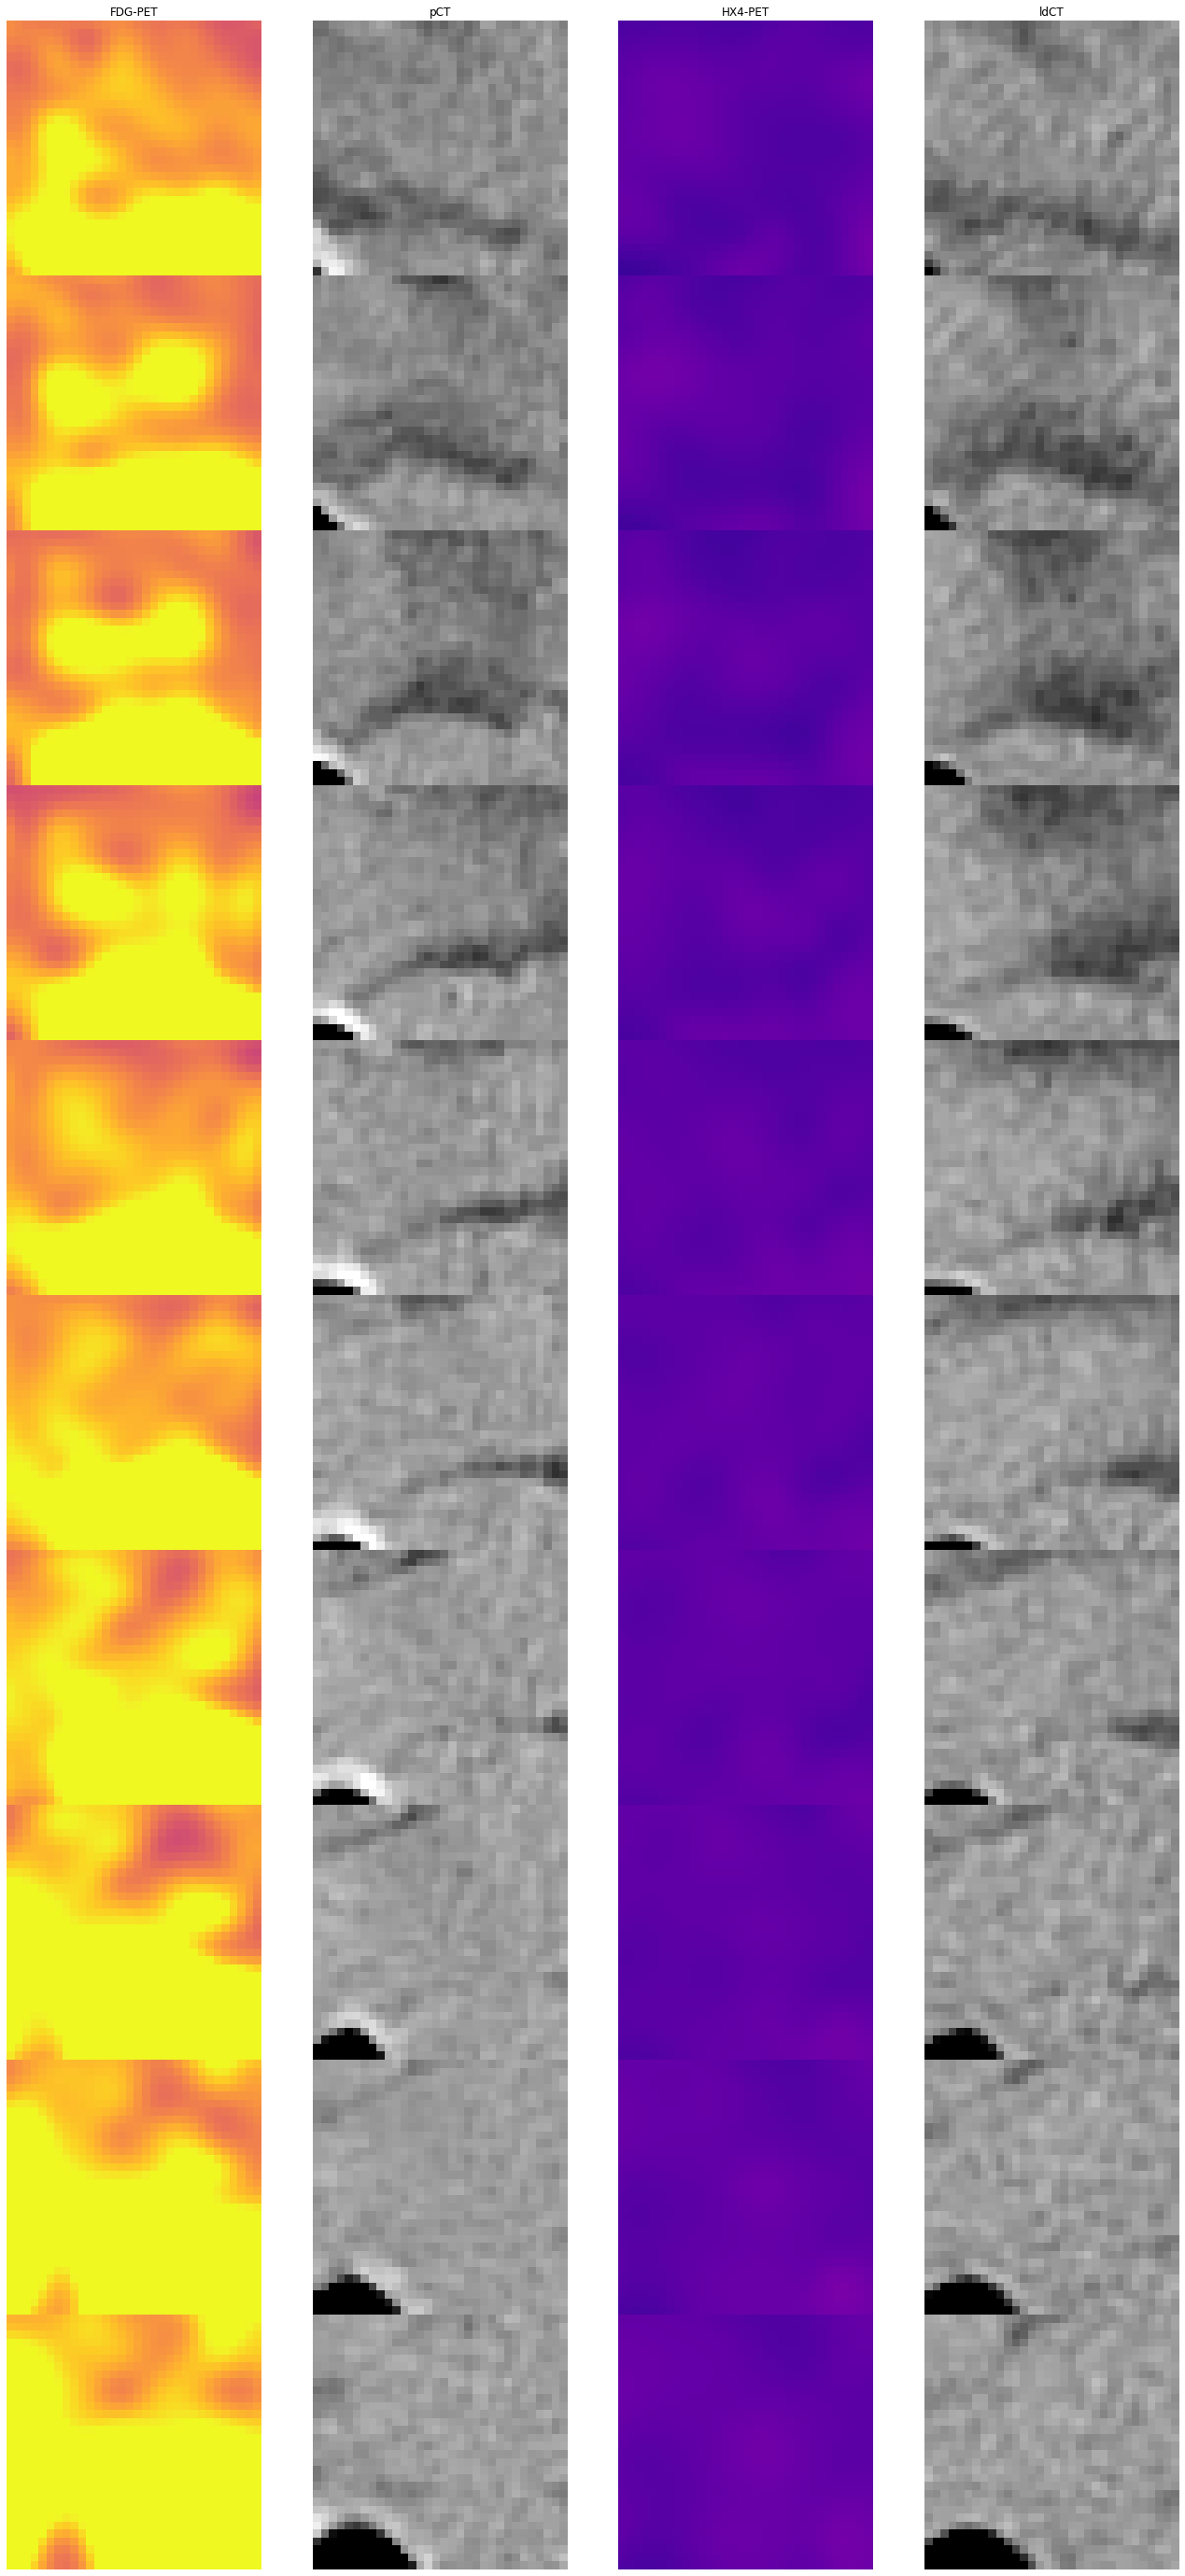

In [9]:
# Visualization
fdg_pet = sample['A'][0, :, :, :].numpy().transpose(2,1,0)
pct = sample['A'][1, :, :, :].numpy().transpose(2,1,0)
hx4_pet = sample['B'][0, :, :, :].numpy().transpose(2,1,0)
ldct = sample['B'][1, :, :, :].numpy().transpose(2,1,0)

visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([fdg_pet, pct, hx4_pet, ldct], 
                              image_types=['PET', 'CT', 'PET', 'CT'], 
                              idx_range=[0, 10], 
                              view='axial',
                              subtitles=['FDG-PET', 'pCT', 'HX4-PET', 'ldCT'])

In [10]:
# # Sampler testing


# images_A, images_B = {}, {}
# images_A['FDG-PET'] = sitk.ReadImage(f"{root_path}/PB047/fdg_pet.nrrd")
# images_A['pCT'] = sitk.ReadImage(f"{root_path}/PB047/pct.nrrd")
# images_A['body-mask'] = sitk.ReadImage(f"{root_path}/PB047/pct_body.nrrd")
# images_B['HX4-PET-reg'] = sitk.ReadImage(f"{root_path}/PB047/hx4_pet_reg.nrrd")
# images_B['ldCT-reg'] = sitk.ReadImage(f"{root_path}/PB047/ldct_reg.nrrd")
# images_B['body-mask'] = sitk.ReadImage(f"{root_path}/PB047/pct_body.nrrd")

# images_A = sitk2np(images_A)
# images_B = sitk2np(images_B)

# images_A = apply_body_mask(images_A)
# images_B = apply_body_mask(images_B)

# patch_sampler = PairedPatchSampler3D(patch_size, sampling='uniform-random')

In [11]:
# visualizer.set_spacing((1,1,3))
# visualizer.multi_image_strips([images_A['FDG-PET'].transpose(2,1,0), images_A['pCT'].transpose(2,1,0), 
#                                images_B['HX4-PET-reg'].transpose(2,1,0), images_B['ldCT-reg'].transpose(2,1,0)], 
#                               image_types=['PET', 'CT', 'PET', 'CT'], 
#                               idx_range=[20, 22], 
#                               view='axial',
#                               subtitles=['FDG-PET', 'pCT', 'HX4-PET', 'ldCT'])

In [12]:
# while True:
#     focal_point = patch_sampler._sample_focal_point(images_A, images_B)

#     patch_size = np.array(patch_size)

#     start_idx = focal_point - np.floor(patch_size/2)
#     end_idx = start_idx + patch_size
#     z1, y1, x1 = start_idx.astype(np.uint16)
#     z2, y2, x2 = end_idx.astype(np.uint16)
    
#     if (z2-z1, y2-y1, x2-x1) != (32, 32, 32):
#         print(focal_point, z2-z1, y2-y1, x2-x1)